## ANALISIS DE SENTIMIENTOS

- Gabriel Quiroz
- Jose Ponce

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

import re, string, unicodedata

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [4]:
df = pd.read_csv("./datos/train.csv", index_col=0)


### Preprocesamiento de Datos


Primero obtenemos un panorama general de los datos observando el encabezado del dataframe

In [6]:
df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [8]:
profile = ProfileReport(df)
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Se convierte el texto a minusculas

In [5]:
df["clean_text"] = df["text"].str.lower()


Se remueven los caracteres especiales

In [6]:
df["clean_text"] = df["clean_text"].str.replace("""[#,@,&,']""", '', regex=True)


Se remueven las URL

In [7]:
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])


Se remueven los emojis

In [8]:
filter_char = lambda c: ord(c) < 256
df['clean_text'] = df['clean_text'].apply(lambda s: ''.join(filter(filter_char, s)))

Se eliminan todos los signos de puntuacion

In [9]:
df['clean_text'] = df['clean_text'].str.replace(r'[^\w\s]+', '', regex=True)


Se quitan los artículos, preposiciones y conjunciones (stopwords),como lo pueden ser ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, y ‘they’. Eliminar estas palabras vacías se vuelve mucho más útil cuando comenzamos a usar secuencias de palabras más largas como características del modelo, gracias a esto el rendimiento del modelo mejora.


In [10]:
english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

df["clean_text"] = remove_stop_words(df["clean_text"])

Se eliminan los numeros

In [11]:
df["clean_text"] = df["clean_text"].str.replace('\d+', '', regex=True)


Se normalizan las palabras del texto tratando de convertir todas las diferentes formas de una palabra dada en una sola, esto a travez del metodo Lematization, este identifica la parte del discurso de una palabra dada y aplica reglas complejas para transformar la palabra en su verdadera raiz.

In [12]:
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

df["clean_text"] = get_lemmatized_text(df["clean_text"])

Tras Limpiar y preprocesar los datos, se puede observar un dataframe mas limpio para el analisis de los datos

In [17]:
df.head()

,keyword,location,text,target,clean_text
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


Se realiza el split del texto para poder analizar las palabras como unigramas

In [20]:
df["clean_text"] = df["clean_text"].str.split()


De igual forma se transforma cada elemento de la lista clean_text en una fila para poder analizar las palabras con mayor facilidad

In [21]:
df_clean = df.explode(column='clean_text')
df_clean = df_clean.drop(columns='text')

In [20]:
df_clean.head()

,keyword,location,target,clean_text
id,,,,
1,NaN,NaN,1,deed
1,NaN,NaN,1,reason
1,NaN,NaN,1,earthquake
1,NaN,NaN,1,may
1,NaN,NaN,1,allah


Se puede observar la cantidad de palabras tanto para los tweets de desastres y los que no lo son

In [21]:
df_clean.groupby(['target'])['clean_text'].count()

target
0    40156
1    33714
Name: clean_text, dtype: int64

### Analisis Exploratorio


Tras analizar las palabras mas frecuentes, estas 10 mas frecuentes serviran para un mejor modelo, , de igual forma a travez de los bigramas y trigramas se puede analizar de mejor manera el contexto ya que se puden clasificar con mayor facilidad los mensajes positivos y negativos, asi mismo se pueden analizar las palabras mas frecuentes por separado para cada categoria para de esta manera seleccionar las que mas aporten para el modelo

In [74]:
n = 10
df_clean['clean_text'].value_counts().nlargest(n)

fire      350
like      347
amp       300
im        299
get       255
u         253
new       224
one       204
people    199
via       193
Name: clean_text, dtype: int64

Tras analizar las palabras mas frecuentes, tanto en los tweets de desastres y los que no son relacionados a los desastres, las 10 mas frecuentes de cada uno serviran para el modelo, a excepcion de las palabras "u" y "im"

In [76]:
n = 10
mayor_frecuencia_desastre = df_clean[df_clean['target'] == 1]['clean_text'].value_counts().nlargest(n)
mayor_frecuencia_desastre

fire          262
news          136
disaster      118
california    115
via           112
suicide       110
u             107
police        107
amp           107
people        106
Name: clean_text, dtype: int64

In [77]:
n = 10
mayor_frecuencia_no_desastre = df_clean[df_clean['target'] == 0]['clean_text'].value_counts().nlargest(n)
mayor_frecuencia_no_desastre

like    255
im      243
amp     193
get     185
new     168
u       146
dont    141
one     135
body    115
time    105
Name: clean_text, dtype: int64

Se puede observar que para los tweets que no son relacionados con desastres, la palabra like que esta relacionada a algo positivo tiende a ser la mas utilizada, mientras que en los tweets de desastres se puede observar que la palabra fire es la mas frecuente, deribado de desastres relacionados con fuego

In [25]:
n = 1
mayor_frecuencia_no_desastre = df_clean[df_clean['target'] == 0]['clean_text'].value_counts()[:n].index.tolist()
mayor_frecuencia_no_desastre

['like']

In [35]:
n = 1
mayor_frecuencia_desastre = df_clean[df_clean['target'] == 1]['clean_text'].value_counts()[:n].index.tolist()
mayor_frecuencia_desastre

['fire']

Se puede observar en la nube de palabras de forma mas grafica las palabras que mas resaltan son las mas frecuentes y de las que menos resaltan son las menos frecuentes, se puede concluir como arriba que de las palabras mas frecuentes ya sean relacionados a desastres o no 'fire', 'like', 'amp', 'im', 'get', 'u', 'new', 'one', 'people' y 'via'.

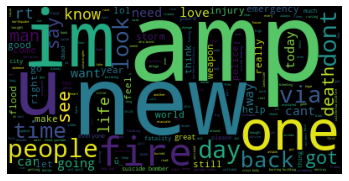

In [53]:
wordcloud = WordCloud().generate(' '.join(map(str, df_clean['clean_text'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Se puede observar en la nube de palabras de de forma mas grafica las palabras en relacion a los tweets de desastre las que mas resaltan son las mas frecuentes y de las que menos resaltan son las menos frecuentes, se puede concluir como arriba que las palabras mas frecuentes en relacion a los desastres son 'fire', 'news', 'disaster', california', 'via', 'suicide', 'u', 'police', 'amp' y 'people'.

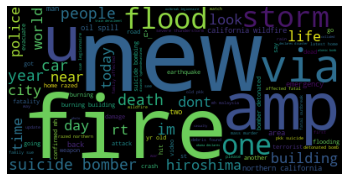

In [59]:
wordcloud = WordCloud().generate(' '.join(map(str, df_clean[df_clean['target'] == 1]['clean_text'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Se puede observar en la nube de palabras de de forma mas grafica las palabras en relacion a los tweets que no son de desastres las que mas resaltan son las mas frecuentes y de las que menos resaltan son las menos frecuentes, se puede concluir como arriba que las palabras mas frecuentes en relacion a los desastres son 'like', 'im', 'amp', 'get', 'new', 'u', 'dont', 'one', 'body' y 'time'.

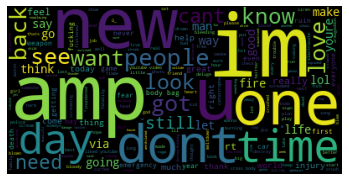

In [60]:
wordcloud = WordCloud().generate(' '.join(map(str, df_clean[df_clean['target'] == 0]['clean_text'])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Al analizar el histograma de las palabras con mas frecuencia de tweets ya sean de desastres o no, se observa que fire y like son las que mas frecuencia tienen, siendo esta de aproximadamene 350 y por ultimo se encuentran via y people con aproximadamente 200 de frecuencia

<AxesSubplot:>

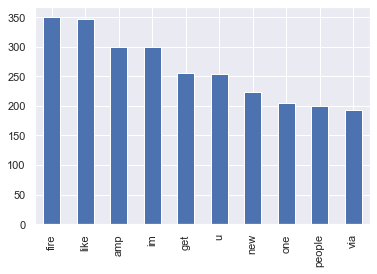

In [72]:
df_clean['clean_text'].value_counts()[:n].plot(kind='bar')

Al analizar el histograma de las palabras con mas frecuencia de tweets de desastres, se observa que fire es la que mas frecuencia tiene, por lo que se infiere que gran parte de los tweets relacionados a desastres pueden ser de incendios, asi mismo se puede observar que las palabras que le siguen, tienen frecuencias entre 100 y 125.

<AxesSubplot:>

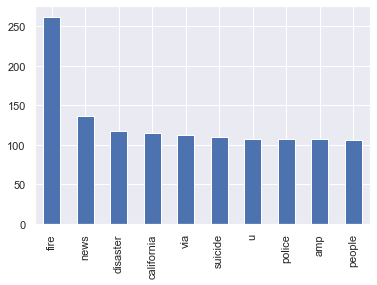

In [70]:
df_clean[df_clean['target'] == 1]['clean_text'].value_counts()[:n].plot(kind='bar')

Al analizar el histograma de las palabras con mas frecuencia de tweets que no son relacionados a desastres, se observa que like y im son las que mas frecuencia tienen, por lo que se infiere que gran parte de los tweets relacionados a publicaciones que hablan de si mismas o publicaciones a las que les han dado like, de igual forma se observa que la que menos frecuencia tiene es time con 125 repeticiones aproximadamente y de igual forma el resto de palabras se mantienen en dichos niveles.

<AxesSubplot:>

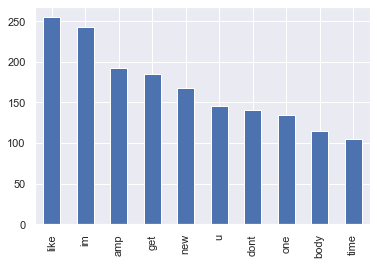

In [71]:
df_clean[df_clean['target'] == 0]['clean_text'].value_counts()[:n].plot(kind='bar')

### Determinar las palabras positivas, negativas o neutras

Se realiza una funcion utilizando la libreria textBlob la cual permite analizar una palabra y decirnos si es positiva, negativa o neutral

In [3]:
from textblob import TextBlob

In [36]:
def sentiment(word): 
    if TextBlob(word).sentiment.polarity > 0: 
        return 'positiva'
    elif TextBlob(word).sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negativa'

In [38]:
sentimiento = pd.Series(df_clean['clean_text']).apply(lambda x: sentiment(str(x)))
sentimiento

id
1        neutral
1        neutral
1        neutral
1        neutral
1        neutral
          ...   
10873    neutral
10873    neutral
10873    neutral
10873    neutral
10873    neutral
Name: clean_text, Length: 73874, dtype: object

Cantidad de palabras neutrales, positivas y negativas

In [42]:
sentimiento.value_counts()

neutral     67880
positiva     3581
negativa     2413
Name: clean_text, dtype: int64

Se realiza un diagrama de barras para visualizar la cantidad de palabras neutrales, positivas y negativas

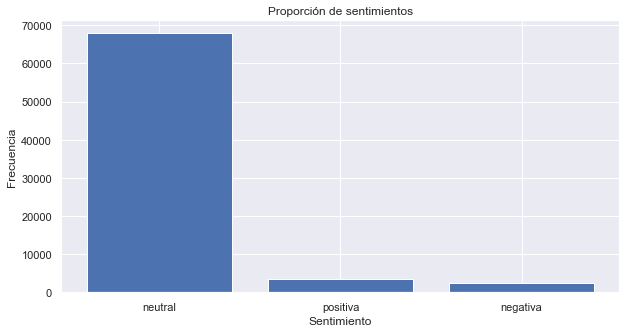

In [39]:
counter = sentimiento.value_counts()
plt.figure(figsize=(10,5))
plt.bar(counter.index, counter.values)
plt.title("Proporción de sentimientos")
plt.ylabel("Frecuencia")
plt.xlabel("Sentimiento")
plt.show()